In [1]:
HOME = '/content/drive/MyDrive/colab/fastsam/'
%cd {HOME}

/content/drive/MyDrive/colab/fastsam


In [2]:
# install FastSAM
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
!pip -q install -r FastSAM/requirements.txt
# install CLIP
!pip -q install git+https://github.com/openai/CLIP.git
# install other dependencies
!pip -q install roboflow supervision jupyter_bbox_widget

fatal: destination path 'FastSAM' already exists and is not an empty directory.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.7/611.7 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.9 MB/s eta 0

In [3]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
!ls -lh {HOME}/weights

total 415M
-rw------- 1 root root 139M Jun 20 07:01 FastSAM.pt
-rw------- 1 root root 139M Jun 20 07:01 FastSAM.pt.1
-rw------- 1 root root 139M Jun 20 07:01 FastSAM.pt.2


In [4]:
FAST_SAM_CHECKPOINT_PATH = f"{HOME}/weights/FastSAM.pt"

## Download images

In [5]:
!mkdir -p {HOME}/data
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/robot.jpeg
!ls -lh {HOME}/data

total 1.6M
-rw------- 1 root root 104K Jun  2 16:01 dog.jpeg
-rw------- 1 root root 104K Jun  2 16:01 dog.jpeg.1
-rw------- 1 root root 104K Jun  2 16:01 dog.jpeg.2
-rw------- 1 root root 426K Jul  5 17:33 robot.jpeg
-rw------- 1 root root 426K Jul  5 17:33 robot.jpeg.1
-rw------- 1 root root 426K Jul  5 17:33 robot.jpeg.2


In [6]:
%cd {HOME}/FastSAM

import os
import cv2
import torch
import roboflow
import base64

import supervision as sv
import numpy as np

from roboflow import Roboflow
from fastsam import FastSAM, FastSAMPrompt

/content/drive/MyDrive/colab/fastsam/FastSAM


In [7]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fast_sam = FastSAM(FAST_SAM_CHECKPOINT_PATH)

In [8]:
IMAGE_PATH = f"{HOME}/data/dog.jpeg"

In [9]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.everything_prompt()
prompt_process.plot(annotations=masks, output_path=f"{HOME}/output/test.jpeg")


image 1/1 /content/drive/MyDrive/colab/fastsam/data/dog.jpeg: 1024x576 30 objects, 97.9ms
Speed: 13.7ms preprocess, 97.9ms inference, 48.3ms postprocess per image at shape (1, 3, 1024, 1024)


In [10]:
def annotate_image(image_path: str, masks: np.ndarray) -> np.ndarray:
    image = cv2.imread(image_path)

    xyxy = sv.mask_to_xyxy(masks=masks)
    detections = sv.Detections(xyxy=xyxy, mask=masks)

    mask_annotator = sv.MaskAnnotator()
    return mask_annotator.annotate(scene=image.copy(), detections=detections)

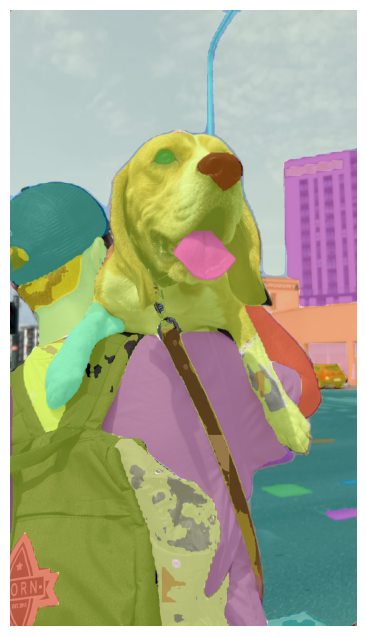

In [11]:
masks = masks.cpu().numpy().astype(bool)
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

In [12]:
# helper function that loads an image before adding it to the widget

def encode_image(filepath):
    # (rb) is useful for image, audio reading
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    # useful for json xml also
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

''
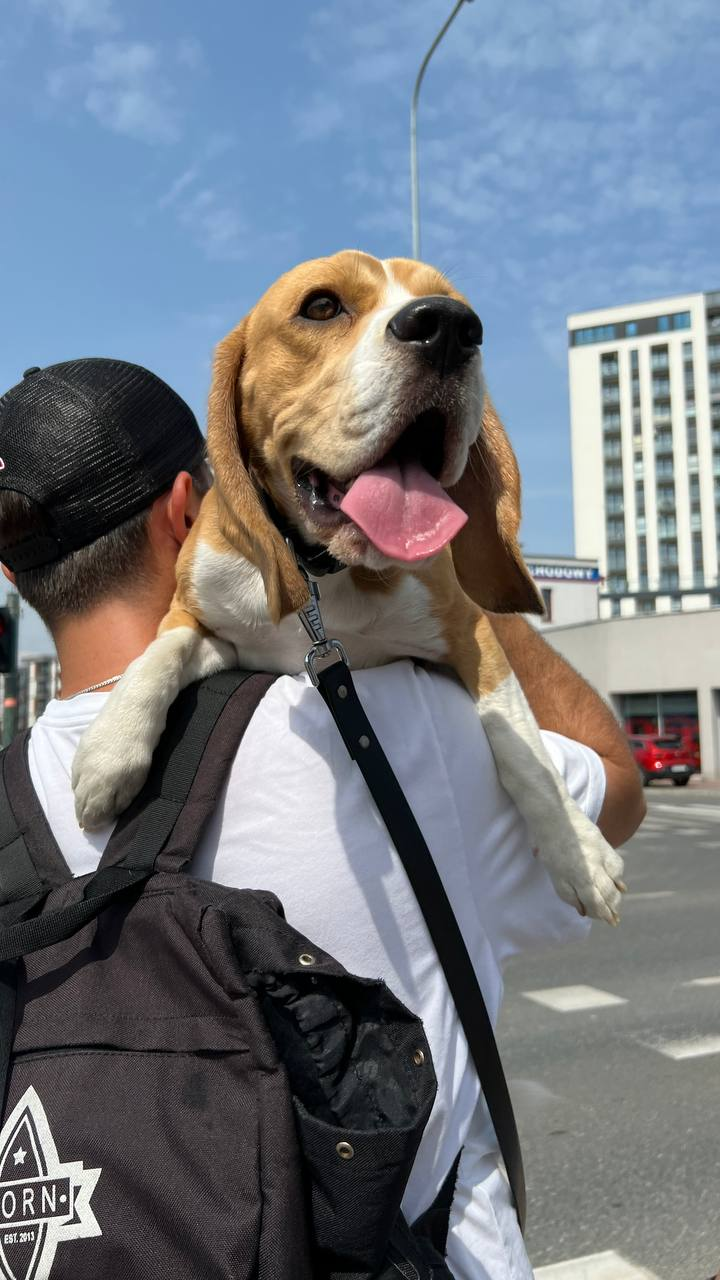

In [13]:
encode_image(IMAGE_PATH)

In [14]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [15]:
widget.bboxes

[{'x': 336, 'y': 463, 'width': 135, 'height': 101, 'label': ''}]

In [16]:
# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = [
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
]

In [17]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.box_prompt(bbox=box)


image 1/1 /content/drive/MyDrive/colab/fastsam/data/dog.jpeg: 1024x576 30 objects, 98.2ms
Speed: 43.0ms preprocess, 98.2ms inference, 11.8ms postprocess per image at shape (1, 3, 1024, 1024)


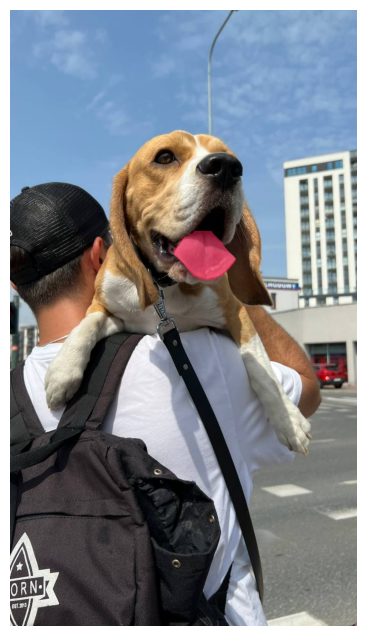

In [18]:
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

## FastSAM point prompt inference

In [25]:
point = [405, 200]

In [26]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.point_prompt(points=[point], pointlabel=[1])


image 1/1 /content/drive/MyDrive/colab/fastsam/data/dog.jpeg: 1024x576 30 objects, 116.0ms
Speed: 5.4ms preprocess, 116.0ms inference, 7.4ms postprocess per image at shape (1, 3, 1024, 1024)


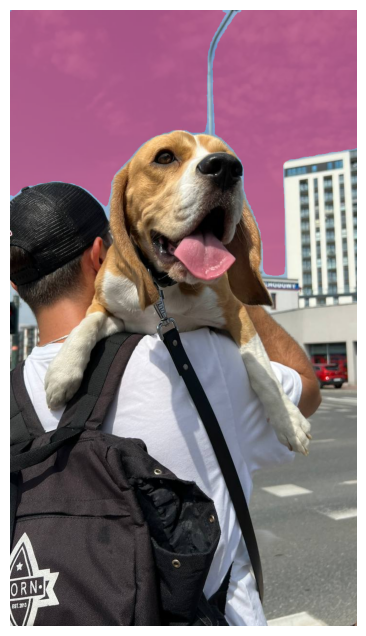

In [27]:
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

## FastSAM text prompt inference

In [34]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.text_prompt(text='building')


image 1/1 /content/drive/MyDrive/colab/fastsam/data/dog.jpeg: 1024x576 30 objects, 105.5ms
Speed: 3.7ms preprocess, 105.5ms inference, 5.9ms postprocess per image at shape (1, 3, 1024, 1024)


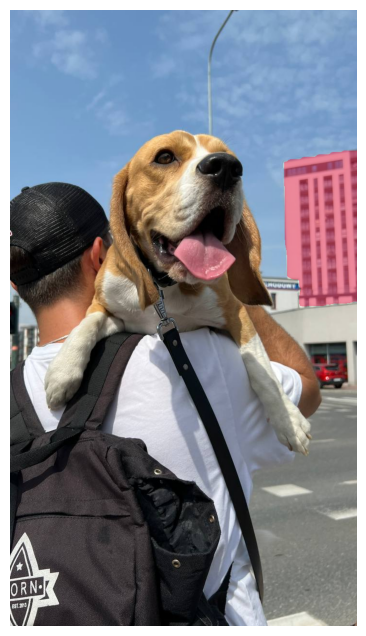

In [35]:
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

In [ ]:
#Source - Thanks to roboflow team
#https://www.youtube.com/watch?v=yHNPyqazYYU